In [1]:
from scipy.linalg import eigh_tridiagonal

import numpy as np
import matplotlib.pyplot as plt

from jupyterthemes import jtplot
jtplot.style(theme='monokai', context='notebook', ticks=True, grid=True)

np.set_printoptions(precision=3, suppress=True)

In [15]:
def get_bloch_spectrum(V0, kl, q, l_max):
    l = np.arange(-l_max, l_max+1)
    E, psi = eigh_tridiagonal((2 * l + q/kl) ** 2 + V0/2, -V0/4 * np.ones(len(l) - 1))
    return np.real(E), psi.T

# Define periodic potential
$$V = V_0 \cdot \sin^2(k_l x)$$

In [16]:
V0, kl = 10, np.pi #potential depth, period

# Construct and diagonalize hamiltonian

Expand the bloch wave-functions in the free-particle basis:

$$u_q(x) \approx \sum_{j = -l_{max}}^{l_{max}} e^{2ik_l \cdot j \cdot x}$$

and we calculate the spectrum over the first brillouin zone, $q \in [-k_l, k_l]$.

In [17]:
l_max = 10
q = np.linspace(-kl, kl, 100)

psi = np.empty((len(q), 2 * l_max + 1, 2 * l_max + 1), dtype = np.complex128)
E = np.empty((len(q), 2 * l_max + 1))

for i, k in enumerate(q):
    E[i], psi[i] = get_bloch_spectrum(V0, kl, k, l_max)

# Construct wannier functions

In [18]:
# # k is index of wave-number
def to_pos_basis(phi_l, kl, l_max):
    l = np.arange(-l_max, l_max+1)
    def phi_x(x):
        return np.sum(phi_l * np.exp(2j * kl * x * l))
    
    return phi_x
    
def func_wannier(bloch_fn, k, R):
    def func(x):
        bloch_vals = np.array([fn(x) for fn in bloch_fn])
        return 1/len(k) * np.sum(bloch_vals * np.exp(1j * k * (x - R)), axis = 0)

    return func

In [19]:
bloch = [to_pos_basis(f[0], kl, l_max) for f in psi]
wannier = func_wannier(bloch, q, 0)

x = np.linspace(-5, 5, 1001) #domain
V = V0 * np.sin(np.pi * x) ** 2

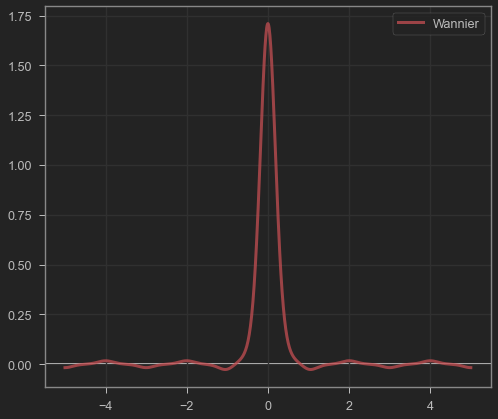

In [20]:
plt.plot(x, np.real(np.vectorize(func_wannier(bloch, q, 0))(x)), label = f"Wannier", alpha = 0.75, c = "C23", lw = 3)
# plt.plot(x, np.abs(np.vectorize(psi_x[0])(x))**2, label = "Bloch (q = 0)")
plt.ticklabel_format(useOffset=False, style='plain')
plt.axhline(0, c = "white", zorder = -1)
plt.legend()

# Determine BHM parameters

In [10]:
def tunneling_1D(Ri, Rj, bloch_energy, k): 
    return - 1/len(k) * np.real(np.sum(bloch_energy * np.exp(-1j * k * (Rj - Ri))))

In [11]:
print([tunneling_1D(0, i, E[:, 0], q) for i in range(5)])

[-2.885228689668976, 0.048227312567474555, -0.02946165037570392, 0.02924089691946696, -0.02923677973365124]


In [12]:
kl = np.pi
l_max = 10
q = np.linspace(-kl, kl, 700)
E = np.empty((len(q), 2 * l_max + 1))

V = np.linspace(0., 20., 100)
t = np.empty((len(V)))
J = np.empty((len(V)))

for (i, V0) in enumerate(V):
    for (j, k) in enumerate(q):
        E[j], _ = get_bloch_spectrum(V0, kl, k, l_max)

    t[i] = tunneling_1D(0, 0, E[:, 0], q)
    J[i] = tunneling_1D(0, 2, E[:, 0], q)

Text(0.5, 0, 'V/$E_r$')

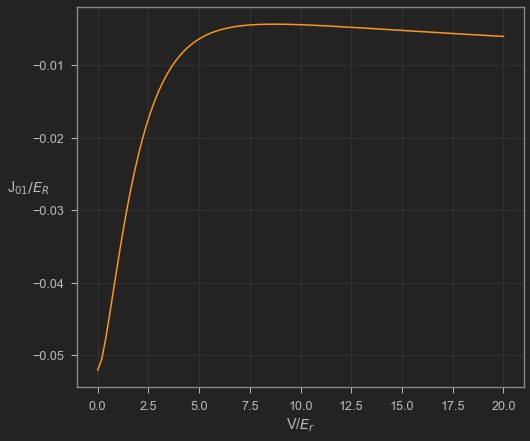

In [39]:
plt.plot(V, J, c = "C15")
plt.ylabel(r"J$_{01}/E_R$", rotation = 0)
plt.xlabel(r"V/$E_r$")

In [10]:
from scipy.fft import fft, fftfreq, fftshift, ifftshift

In [22]:
wannier = func_wannier(bloch, q, 0)

n, L = 100, 10.
x = np.linspace(-L/2, L/2, n, endpoint=True)
y = np.conj(np.vectorize(wannier)(x)) * np.vectorize(wannier)(x - 1)

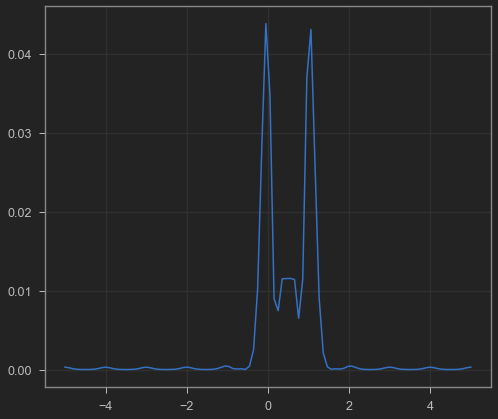

In [29]:
plt.plot(x, np.abs(y))

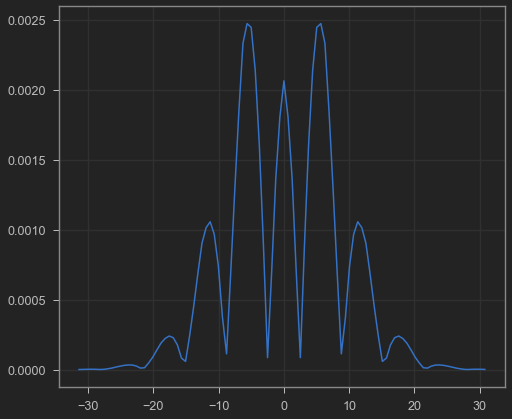

In [20]:
k_space = (2*np.pi/L) * np.arange(-n/2, n/2)

yf = fftshift(fft(y))
plt.plot(k_space, 1.0/n * np.abs(yf))

In [207]:
N, Xa = 10000, 100
dx = Xa/N
dk = 2 * np.pi/Xa

x_grid = np.linspace(-Xa/2, Xa/2, N, endpoint = False)
k_grid = np.linspace(-np.pi/dx, np.pi/dx, N, endpoint = False)

In [208]:
y = np.conj(np.vectorize(wannier)(x_grid)) * np.vectorize(wannier)(x_grid - 1)

(-10.0, 10.0)

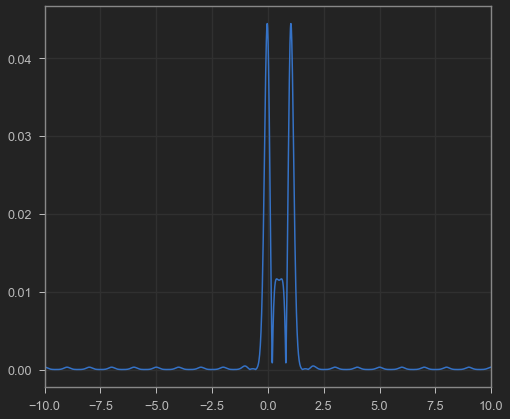

In [212]:
plt.plot(x_grid, np.abs(y))
plt.xlim([-10, 10])

In [216]:
yt = fftshift(fft(y))

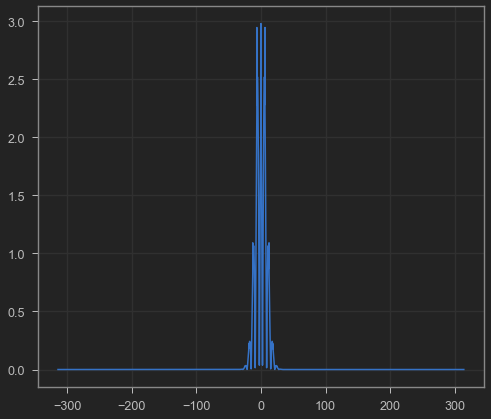

In [217]:
plt.plot(k_grid, np.abs(yt))